# Driven composite systems and interface with QuTiP in scQubits

Systems of interest in quantum computing generally involve mutual coupling between multiple quantum systems.
By driving these individual subsystems, we can perform single- or multi-qubit gates.

In the context of superconducting circuits, a common method of driving a circuit is to capacitively couple a voltage bias to one or multiple nodes of the circuit. 
By a proper choice of drive frequency, amplitude and envelope, logical operations can be achieved.

The popular Python package QuTiP can be used to simulate the time dynamics of quantum systems. 
For the simulation of superconducting circuits, scQubits provides a transparent interface to QuTiP through the `HilbertSpace` class.

These notebooks showcase how scQubits can be easily used to simulate dynamics of driven superconducting circuits through examples from the literature. The notebook
`FluxoniumRestTutorial.ipynb` provides a tutorial for using scQubits to simulate the heavy-fluxonium initialization procedure described in [Universal fast flux control of a coherent, low-frequency qubit](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010) by Zhang et al. The notebook `FluxoniumCZTutorial.ipynb` contains a tutorial for using scQubits to simulate the procedure for effecting a CZ-gate on a coupled pair of fluxonium qubits described by Nesterov et al. in [Microwave-Activated Controlled-Z Gate for Fixed-Frequency Fluxonium Qubits.](https://arxiv.org/abs/1802.03095)

# Heavy-fluxonium initialization tutorial

B. McDonough

This notebook provides a tutorial for using scQubits to simulate the heavy-fluxonium initialization procedure described in [Universal fast flux control of a coherent, low-frequency qubit](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010) by Zhang et al.

For a typical heavy-fluxonium qubit, the frequency of the transition between the first two energy levels is small in comparison to the temperature of the bath. Thus the qubit relaxes to a mixed state, in contrast to higher-frequency transmon qubits which typically relax to the ground state. The coupling to a low-Q resonator provides the non-unitary process needed to remove entropy from this state.

To summarize this procedure, the qubit begins in a nearly completely mixed state between the first two energy levels, $\rho \approx \frac{1}{2}(|g\rangle \langle g| +|e\rangle \langle e|)\otimes |0\rangle \langle 0 |$. The first four levels of the fluxonium are labeled with $g,e,f,h$ respectively, and the resonator Fock states are labeled with numbers. The transitions $|g0\rangle$ to $|h0\rangle$ and $|h0\rangle$ to $|e1\rangle$ are driven simulataneously for a period of 15 $\mu$ s. Throughout this process, photon loss in the resonator causes the population of $|e1\rangle$ to transition to $|e0\rangle$. The system eventually reaches a steady state, preparing $|e0\rangle$ with high fidelity.

The Hamiltonian of the coupled fluxonium-resonator system with a drive at frequency $\omega_d$ capacitively coupled to the resonator is
$$
H = 4E_C\hat n - E_J \cos(\hat \phi-\pi) + \frac{1}{2}E_L \hat \phi^2 + g \hat n (a+a^\dagger) + E_{osc}a^\dagger a + f(t)\cos(\omega_d t)(a+a^\dagger)
$$

In [1]:
import sys
sys.path.append("/home/ben/Documents/Repos/scqubits")

import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
import scqubits as scq

# experimental values borrowed from
# https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010
qbt = scq.Fluxonium(
    EJ=3.395,
    EC=0.479,
    EL=0.132,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=10,
    id_str="qubit"
)

osc = scq.Oscillator(E_osc=5.7, truncated_dim=8, id_str="resonator")

hilbertspace = scq.HilbertSpace([qbt, osc])

hilbertspace.add_interaction(
    g_strength=.4, op1=qbt.n_operator, op2=osc.creation_operator, add_hc=True
)

# Precompute eigensystem to save later computation
hilbertspace.generate_lookup()

## Drive simulation methods

In [2]:
# get the transition frequency between two states specified by dressed indices
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )

# Get the period of one Rabi cycle as a function of operator matrix element and drive strength
def drive_strength(s0: int, s1: int, period: float, drive_operator: qt.Qobj):
    # divide by 2pi for drive strength in units of GHz
    return abs(1 / (period * drive_operator.data.toarray()[s0][s1]))

def rabi_period(s0: int, s1: int, Omega: float, drive_operator: qt.Qobj):
    # divide by 2pi for period in units of ns
    return abs(1 / (Omega * drive_operator.data.toarray()[s0][s1]))

## Truncating operators
The efficiency of the simulation is greatly improved by truncating the operators.  The truncation happens in two steps:
1) The first truncation is controlled by setting the `truncated_dim` parameter in the subsystem initialization, which determines the dimension used in diagonalizing the Hamiltonian. Setting these too low can result in an unphysical simulation. Even if energy levels above the truncation are not explicitly involved, they can still drastically affect the matrix elements of the operators. 

2) Once the matrix elements and eigenvalues have been obtained, the operators can be truncated further. This truncation can greatly improve the runtime of the simulation. 

Here, a coupled system with dimensions $10$ by $8$ is simulated. These truncation levels are reasonable to obtain the operators for each individual system. However, this results in a full Hamiltonian represented by an $80 \times 80$ matrix. After diagonalization, the Hamiltonian and subsystem operators can be safely truncated to a lower dimension, specified here by the variable `total_truncation`.

In [3]:
# The matrix representations can be truncated further for the simulation
total_truncation = 20

# truncate operators to desdired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

## Drive operators

In [4]:
# express the resonator drive operator in the dressed eigenbasis of the system
phi_r = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator) \
    + hilbertspace.op_in_dressed_eigenbasis(op=osc.creation_operator)

#truncate operator for more efficient simulation
phi_r_trunc = truncate(phi_r, total_truncation)

# do the same for the qubit charge operator
n_qbt = hilbertspace.op_in_dressed_eigenbasis(op=qbt.n_operator)

#truncate operator
n_qbt_trunc = truncate(n_qbt, total_truncation)

The dressed eigenstates correspond closely to the bare product states when the coupling is weak. The `dressed_index` function matches a product state to the corresponding dressed eigenstate.

In [5]:
#Get energy indices most closely matching product state indices
g0 = hilbertspace.dressed_index((0,0))
e0 = hilbertspace.dressed_index((1,0))
h0 = hilbertspace.dressed_index((3,0))
e1 = hilbertspace.dressed_index((1,1))

# Get eigenstates matching product state dressed indices
states = [qt.basis(total_truncation, i) for i in [g0, e0, h0, e1]]
period = 500
Omega1 = drive_strength(g0, h0, period, phi_r)
Omega2 = drive_strength(h0, e1, period, phi_r)

# g0 -> h0 transition
omega_1 = transition_frequency(h0, g0)
# h0 -> e1 transition
omega_2 = transition_frequency(e1, h0)

# drive amplitude as a function of time
def drive_coeff(t : float, args : dict) -> float:
    return Omega1 * np.cos(omega_1 * t) + Omega2 * np.cos(omega_2 * t)

# get the diagonal Hamiltonian in the dressed basis
(evals,) = hilbertspace["evals"]

## Units
scQubits natively reports energy in GHz, units of frequency. The frequency $f$ and the radial frequency $\omega$ are related via
$$
\hbar \omega = h f
$$
The constants $h$ and $\hbar$ are related by $h = 2\pi \hbar$, so the angular frequency in units of radians per nanosecond is given by $\omega = 2\pi f$. For this reason, the energies obtained from diagonalization and the matrix elements need to be multiplied by $2\pi$ for simulating in QuTiP.

In [6]:
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = qt.Qobj(
    2 * np.pi * np.diag(evals), dims=[hilbertspace.subsystem_dims] * 2
)
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

# The time-dependent driven Hamiltonian
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    #Another factor of 2pi is needed to convert energy to units where time is in ns
    [2 * np.pi * phi_r_trunc, drive_coeff],  # driving through the resonator
]

## Resonator photon loss
The resonator photon loss is modeled through the quantum channel $\mathcal{E}(\rho) = \kappa a\rho a^\dagger$, defined by the collapse operator $\sqrt{\kappa } a$.

In [7]:
# resonator decay constant
kappa = 0.003
# annihilation operator
a_osc = truncate(
    #basis_change(osc.annihilation_operator(), osc, hilbertspace), total_truncation
    hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator),
    total_truncation
)

## Simulation

In [8]:
# initial mixed state
thermal_state = 0.5 * (states[0] * states[0].dag() + states[1] * states[1].dag())

tlist = np.linspace(0, 15000, 15000)  # total time

result = qt.mesolve(
    H_qbt_drive,  # hamiltonian
    thermal_state,  # initial density matrix
    tlist,
    e_ops=[state * state.dag() for state in states],  # expectation values
    c_ops=[np.sqrt(kappa) * a_osc],  # photon loss
)

Text(0, 0.5, 'population')

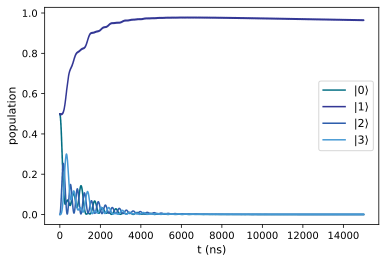

In [9]:
for i in range(4):
    plt.plot(tlist, result.expect[i], label=r"$|%u\rangle$" % (i))
plt.legend()
plt.xlabel("t (ns)")
plt.ylabel("population")

In [10]:
print("Fidelity:", result.expect[1][-1])

Fidelity: 0.9640952114150372
